In [5]:
from functools import partial
import itertools
import json
import math
from multiprocessing import Pool
import os
import pickle
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import cv2
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
np.bool = bool
import pandas as pd
from PIL import Image
from skimage import measure, morphology, segmentation
import torch.nn as nn
from tqdm import tqdm, trange

# Load meta data

In [6]:
TOTAL_LENGTH = 247678
smc_data_path = "/scratch/users/xikunz2/stable-diffusion"
image_path = f"{smc_data_path}/hpa-webdataset-all-composite/images2"
mask_path = f"{smc_data_path}/hpa-webdataset-all-composite/masks2"
with open(f"{smc_data_path}/hpa-webdataset-all-composite/HPACombineDatasetInfo.pickle", 'rb') as fp:
    info_list = pickle.load(fp)
assert len(info_list) == TOTAL_LENGTH

In [3]:
info_list[0]

{'filename': '/archive/1680/1680_F4_5_',
 'if_plate_id': 1680,
 'position': 'F4',
 'sample': 5,
 'status': 35,
 'Image status name': 'Annotated / Proteinatlas',
 'locations': 'Cell Junctions',
 'staining characteristics': nan,
 'unspecific': 0.0,
 'antibody': 'HPA077995',
 'ensembl_ids': 'ENSG00000253537',
 'gene_names': 'PCDHGA7',
 'atlas_name': 'SH-SY5Y',
 'versions': '16.0,16.1,17.0',
 'earliest_version': 16.0,
 'first_released': '2016-12-04 14:00:00',
 'latest_version': 17.0,
 'Spatial cell cycle': nan,
 'Intensity cell cycle': nan,
 'Annotated cell cycle': 0.0,
 'gain': 800.0,
 'Ab state': 'IF_FAILED',
 'Max tpm': 19.76,
 'Finished in genes': nan,
 'Protocol': 'PFA',
 'Gene reliability (in release)': nan,
 'Gene reliability (lims)': nan,
 'Cell count': 24.0,
 'well_location_predictions_all': nan,
 'image_id': '77995_1680_F4_5',
 'sequences': ['>sp|Q9Y5G6|PCDG7_HUMAN Protocadherin gamma-A7 OS=Homo sapiens OX=9606 GN=PCDHGA7 PE=2 SV=1\nMAAQPRGGDYRGFFLLSILLGTPWEAWAGRILYSVSEETDKGSFVGD

In [7]:
with open(f"{smc_data_path}/hpa-webdataset-all-composite/stage1_data_split_flt4.json") as in_file:
    idcs = json.load(in_file)
train_indexes = idcs["train"]
valid_indexes = idcs["validation"]
all_indexes = train_indexes + valid_indexes
len(all_indexes), len(train_indexes)

(73236, 69800)

# Get segmentation masks

In [5]:
def get_masks(segmentator, image_path, mask_path):
    # for idx, row in tqdm(no_mask_df.iterrows(), total=len(no_mask_df)):
    c = 0
    for idx in tqdm(all_indexes):
        info = info_list[idx]
        plate_id = info["if_plate_id"]
        position = info["position"]
        sample = info["sample"]
        name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
        if not os.path.exists(f"{mask_path}/{name_str}_cellmask.png") or not os.path.exists(f"{mask_path}/{name_str}_nucleimask.png"):
            c += 1
            im = Image.open(f'{image_path}/{idx}.tif')
            imarray = np.array(im)
            assert imarray.shape == (1024, 1024, 4)
            image_mt, image_er, image_nuc = imarray[:, :, 0], imarray[:, :, 3], imarray[:, :, 2]

            image = [[image_mt], [image_er], [image_nuc]]

            nuc_segmentation = segmentator.pred_nuclei(image[2])
            cell_segmentation = segmentator.pred_cells(image)

            # post-processing
            nuclei_mask = label_nuclei(nuc_segmentation[0])
            nuclei_mask, cell_mask = label_cell(nuc_segmentation[0], cell_segmentation[0])

            assert np.max(nuclei_mask) > 0 and np.max(cell_mask) > 0, f"No nuclei or cell mask found for {idx}"
            # fig, axes = plt.subplots(1, 2)
            # axes[0].imshow(nuclei_mask)
            # axes[1].imshow(cell_mask)

            im = Image.fromarray(cell_mask)
            im.save(f"{mask_path}/{name_str}_cellmask.png")
            im = Image.fromarray(nuclei_mask)
            im.save(f"{mask_path}/{name_str}_nucleimask.png")
            # break
    print(c)


NUC_MODEL = f"{smc_data_path}/nuclei_model.pth"
CELL_MODEL = f"{smc_data_path}/cell_model.pth"
segmentor = cellsegmentator.CellSegmentator(
    NUC_MODEL, CELL_MODEL, device="cuda", padding=True, multi_channel_model=True, scale_factor=0.5
)
for m in itertools.chain(segmentor.nuclei_model.modules(), segmentor.cell_model.modules()):
    if isinstance(m, nn.Upsample):
        m.recompute_scale_factor = None
# get_masks(segmentor, image_path, mask_path)

please compile abn


/home/groups/emmalu/xikunz2/miniconda3/envs/ldm2/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/groups/emmalu/xikunz2/miniconda3/envs/ldm2/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/groups/emmalu/xikunz2/miniconda3/envs/ldm2/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Se

# Clean up segmentation masks and get bounding box coordinates

In [8]:
class MyPool:
    def __init__(self, processes, chunksize, initializer, initargs):
        assert type(processes) == int
        assert processes >= 1 or processes == -1
        if processes == -1:
            processes = None
        self.processes = processes
        if processes == 1:
            self.map_func = map
            if initializer is not None:
                initializer(*initargs)
        else:
            self.pool = Pool(processes, initializer=initializer, initargs=initargs)
            self.map_func = self.pool.imap
            if processes is not None:
                self.map_func = partial(self.map_func, chunksize=chunksize)
     
    def __enter__(self):
        if self.processes != 1:
            self.pool.__enter__()
        return self
 
    def __exit__(self, *args):
        if self.processes != 1:
            return self.pool.__exit__(*args)

def get_single_cell_mask(
    cell_mask,
    nuclei_mask,
    closing_radius=7,
    rm_border=True,
    remove_size=1000,
    merge_nuclei=True
):
    init_total_labels = len(np.unique(nuclei_mask)) - 1

    if rm_border:
        nuclei_mask = segmentation.clear_border(nuclei_mask, buffer_size=5)
        keep_value = np.unique(nuclei_mask)
        # borderedcellmask = np.array([[x_ in keep_value for x_ in x] for x in cell_mask]).astype("uint8")
        borderedcellmask = np.isin(cell_mask, keep_value).astype("uint8")
        cell_mask = cell_mask * borderedcellmask
        num_removed_border = init_total_labels - len(keep_value) + 1
        # print(f"Removed {num_removed} cells from border out of {init_total_labels} cells", flush=True)

    if merge_nuclei:
        ### see if nuclei are touching and merge them
        bin_nuc_mask = nuclei_mask > 0
        cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(closing_radius))
        # get the labels of touching nuclei
        new_label_map = morphology.label(cls_nuc)
        new_label_idx = np.unique(new_label_map)[1:]

        new_cell_mask = np.zeros_like(cell_mask)
        new_nuc_mask = np.zeros_like(nuclei_mask)
        for new_label in new_label_idx:
            # get the label of the touching nuclei
            old_labels = np.unique(nuclei_mask[new_label_map == new_label])
            old_labels = old_labels[old_labels != 0]

            new_nuc_mask[np.isin(nuclei_mask, old_labels)] = new_label
            new_cell_mask[np.isin(cell_mask, old_labels)] = new_label
    else:
        new_cell_mask = cell_mask
        new_nuc_mask = nuclei_mask
    num_remove_merge = init_total_labels - num_removed_border - len(np.unique(new_nuc_mask)) + 1

    # assert set(np.unique(new_nuc_mask)) == set(np.unique(new_cell_mask))

    region_props_cell = measure.regionprops(new_cell_mask, intensity_image=(new_cell_mask > 0).astype(np.uint8))
    region_props_nuc = measure.regionprops(new_nuc_mask, intensity_image=(new_nuc_mask > 0).astype(np.uint8))

    region_props = [region_props_cell[i] for (i, x) in enumerate(region_props_nuc) if x.area > remove_size]
    # print(f"Removed {len(region_props_cell) - len(region_props)} out of {len(region_props_cell)} cells", flush=True)
    num_remove_size = len(region_props_cell) - len(region_props)

    assert init_total_labels - num_removed_border - num_remove_merge - num_remove_size == len(region_props), (  # noqa
        init_total_labels,
        num_removed_border,
        num_remove_merge,
        num_remove_size,
        len(region_props),
    )

    if len(region_props) == 0:
        return new_cell_mask, new_nuc_mask, None, None, None, None, None, None
    else:
        bbox_array = np.array([x.bbox for x in region_props])
        ## convert x1,y1,x2,y2 to x,y,w,h
        bbox_array[:, 2] = bbox_array[:, 2] - bbox_array[:, 0]
        bbox_array[:, 3] = bbox_array[:, 3] - bbox_array[:, 1]

        com_array = np.array([x.weighted_centroid for x in region_props])
        bbox_label = np.array([x.label for x in region_props])

        cell_area = np.array([x.area for x in region_props])
        nuc_area = np.array([x.area for x in region_props_nuc if x.area > remove_size])
        return (
            new_cell_mask,
            new_nuc_mask,
            bbox_array,
            com_array,
            bbox_label,
            cell_area,
            nuc_area,
            [
                num_removed_border,
                num_remove_merge,
                num_remove_size,
            ],
        )

filtered_info_list = [info_list[idx] for idx in all_indexes]

In [43]:
def get_bbox_coords(info):
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    # if name_str in images_w_bboxes:
    #     return None
    # else:
    im = Image.open(f"{mask_path}/{name_str}_cellmask.png")
    cell_mask = np.array(im)
    im = Image.open(f"{mask_path}/{name_str}_nucleimask.png")
    nuclei_mask = np.array(im)
    new_cell_mask, new_nuc_mask, bbox_array, com_array, bbox_label, cell_area, nuc_area, removed = get_single_cell_mask(
        cell_mask, nuclei_mask)
    return bbox_array, com_array, bbox_label, cell_area, nuc_area, removed

# n_cpus = 1
# with MyPool(n_cpus, chunksize=16, initializer=None, initargs=None) as p:
#     bbox_coords_list = list(tqdm(p.map_func(get_bbox_coords, filtered_info_list), total=len(all_indexes)))

  0%|                                                                                                                                                           | 0/73236 [00:00<?, ?it/s]

> /tmp/ipykernel_97372/3152420531.py(22)get_single_cell_mask()
     20     ### see if nuclei are touching and merge them
     21     import pdb; pdb.set_trace()
---> 22     bin_nuc_mask = nuclei_mask > 0
     23     cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(closing_radius))
     24     # get the labels of touching nuclei



ipdb>  n


> /tmp/ipykernel_97372/3152420531.py(23)get_single_cell_mask()
     21     import pdb; pdb.set_trace()
     22     bin_nuc_mask = nuclei_mask > 0
---> 23     cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(closing_radius))
     24     # get the labels of touching nuclei
     25     new_label_map = morphology.label(cls_nuc)



ipdb>  


> /tmp/ipykernel_97372/3152420531.py(25)get_single_cell_mask()
     23     cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(closing_radius))
     24     # get the labels of touching nuclei
---> 25     new_label_map = morphology.label(cls_nuc)
     26     new_label_idx = np.unique(new_label_map)[1:]
     27 



ipdb>  


> /tmp/ipykernel_97372/3152420531.py(26)get_single_cell_mask()
     24     # get the labels of touching nuclei
     25     new_label_map = morphology.label(cls_nuc)
---> 26     new_label_idx = np.unique(new_label_map)[1:]
     27 
     28     new_cell_mask = np.zeros_like(cell_mask)



ipdb>  new_label_map


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)


ipdb>  p np.unique(new_label_map)


array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)


ipdb>  q


  0%|                                                                                                                                                           | 0/73236 [11:25<?, ?it/s]


In [40]:
# with open(f"{smc_data_path}/hpa-webdataset-all-composite/bbox_coords.pkl", "wb") as out_file:
#     pickle.dump(bbox_coords_list, out_file)

In [7]:
with open(f"{smc_data_path}/hpa-webdataset-all-composite/bbox_coords.pkl", "rb") as in_file:
    bbox_coords_list = pickle.load(in_file)
len(bbox_coords_list), bbox_coords_list[:2]

73236

In [22]:
assert len(filtered_info_list) == len(bbox_coords_list)
def get_cell_centers(inputs):
    info, (bbox_array, com_array, bbox_label, cell_area, nuc_area, removed) = inputs
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    if com_array is None:
        return [], [], []
    else:
        image_id_list = [name_str] * len(com_array)
        im = Image.open(f"{mask_path}/{name_str}_cellmask.png")
        cell_mask = np.array(im)
        im = Image.open(f"{mask_path}/{name_str}_nucleimask.png")
        nuclei_mask = np.array(im)
        assert cell_mask.shape == nuclei_mask.shape
        downsample_factors = cell_mask.shape / np.array([1024, 1024])
        adjusted_com_array = com_array / downsample_factors
        # print(adjusted_com_array)
        com_y_list = adjusted_com_array[:, 0].tolist()
        com_x_list = adjusted_com_array[:, 1].tolist()
        return image_id_list, com_y_list, com_x_list

# n_cpus = os.cpu_count() - 1
# with MyPool(n_cpus, chunksize=16, initializer=None, initargs=None) as p:
#     com_list = list(tqdm(p.map_func(get_cell_centers, zip(filtered_info_list, bbox_coords_list)), total=len(all_indexes)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 73236/73236 [05:22<00:00, 226.93it/s]


In [23]:
len(com_list)

73236

In [24]:
image_id_list, com_y_list, com_x_list = [[] for _ in range(3)]
for image_id_list_, com_y_list_, com_x_list_ in com_list:
    image_id_list.extend(image_id_list_)
    com_y_list.extend(com_y_list_)
    com_x_list.extend(com_x_list_)
com_df = pd.DataFrame({"image_id": image_id_list, "com_y": com_y_list, "com_x": com_x_list})
com_df

,image_id,com_y,com_x
0,1029_F8_1,111.058786,194.916446
1,1029_F8_1,269.613857,408.210445
2,1029_F8_1,455.109408,601.120633
3,1029_F8_1,601.080531,821.958477
4,1029_F8_1,646.388387,377.500182
...,...,...,...
1011992,36_F2_2,477.487145,766.996744
1011993,36_F2_2,489.121995,374.171645
1011994,36_F2_2,557.857688,510.815798
1011995,36_F2_2,755.140542,263.210319


In [29]:
imageid_to_hpaidx = dict()
for i, info in tqdm(enumerate(info_list), total=len(info_list)):
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    imageid_to_hpaidx[name_str] = i
com_df["hpa_index"] =  com_df["image_id"].apply(lambda x: imageid_to_hpaidx[x])
com_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 247678/247678 [00:00<00:00, 509033.12it/s]


,image_id,com_y,com_x,hpa_index
0,1029_F8_1,111.058786,194.916446,131072
1,1029_F8_1,269.613857,408.210445,131072
2,1029_F8_1,455.109408,601.120633,131072
3,1029_F8_1,601.080531,821.958477,131072
4,1029_F8_1,646.388387,377.500182,131072
...,...,...,...,...
1011992,36_F2_2,477.487145,766.996744,204799
1011993,36_F2_2,489.121995,374.171645,204799
1011994,36_F2_2,557.857688,510.815798,204799
1011995,36_F2_2,755.140542,263.210319,204799


In [30]:
np.unique(com_df["hpa_index"]).shape

(73232,)

In [32]:
# com_df.to_csv(f"{smc_data_path}/hpa-webdataset-all-composite/cell_centers.csv")

In [27]:
for i, info in tqdm(enumerate(info_list), total=len(info_list)):
    plate_id = info["if_plate_id"]
    position = info["position"]
    sample = info["sample"]
    name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
    # print(i, name_str)
    # break
    os.rename(f"{smc_data_path}/hpa-webdataset-all-composite/images2/{i}.tif", f"{smc_data_path}/hpa-webdataset-all-composite/images2/{name_str}.tif")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 247678/247678 [02:48<00:00, 1473.56it/s]


# Visualize bounding boxes

In [9]:
info = filtered_info_list[0]
plate_id = info["if_plate_id"]
position = info["position"]
sample = info["sample"]
name_str = str(plate_id) + "_" + str(position) + "_" + str(sample)
# if name_str in images_w_bboxes:
#     return None
# else:
im = Image.open(f"{mask_path}/{name_str}_cellmask.png")
cell_mask = np.array(im)
im = Image.open(f"{mask_path}/{name_str}_nucleimask.png")
nuclei_mask = np.array(im)
new_cell_mask, new_nuc_mask, bbox_array, com_array, bbox_label, cell_area, nuc_area, [num_removed_border, num_remove_merge, num_remove_size] = get_single_cell_mask(
    cell_mask,
    nuclei_mask)
bbox_array[0]

array([  0,  38, 508, 703])

In [12]:
np.array(Image.open(f"{image_path}/{name_str}.tif")).shape

(1024, 1024, 4)

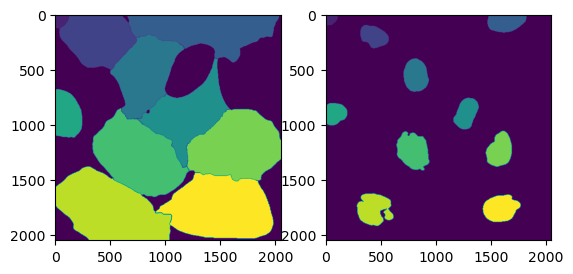

In [9]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cell_mask)
axes[1].imshow(nuclei_mask)

In [16]:
np.unique(cell_mask), np.unique(nuclei_mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

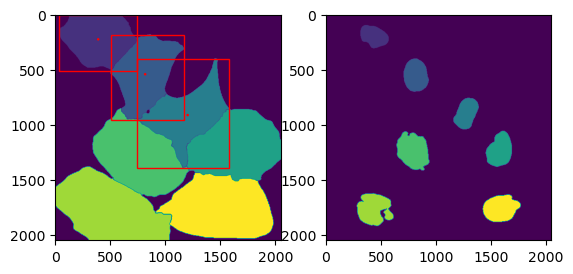

In [35]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(new_cell_mask)
axes[1].imshow(new_nuc_mask)
c = 0
# Create a Rectangle patch
for bbox, com in zip(bbox_array, com_array):
    # bbox: [y, x, height, width]
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    axes[0].add_patch(rect)
    circ = patches.Circle((com[1], com[0]), color="red")
    axes[0].add_patch(circ)
    c += 1
    if c >= 3:
        break
        

In [11]:
new_cell_mask.shape

(2048, 2048)

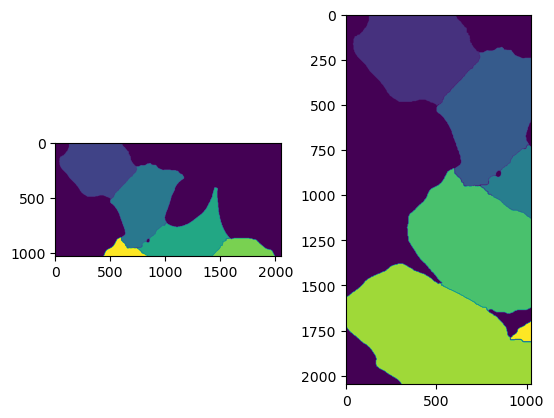

In [13]:
bbox = bbox_array[0]

fig, axes = plt.subplots(1, 2)
# axes[0].imshow(new_cell_mask[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]])
# axes[0].imshow(new_cell_mask[bbox[0]:bbox[0]+bbox[2], bbox[1]:bbox[1]+bbox[3]])
axes[0].imshow(new_cell_mask[:1024])
axes[1].imshow(new_cell_mask[:, :1024])
# axes[1].imshow(new_nuc_mask)

# Visualize segmented cells

In [41]:
with open(f"{smc_data_path}/one_sample.pkl", "rb") as in_file:
    sample = pickle.load(in_file)
sample

{'image': array([[[-0.90588236, -0.90588236, -0.90588236],
         [-0.90588236, -0.90588236, -0.90588236],
         [-0.9529412 , -0.9529412 , -0.9529412 ],
         ...,
         [-0.8352941 , -0.8352941 , -0.8352941 ],
         [-0.88235295, -0.88235295, -0.88235295],
         [-0.88235295, -0.88235295, -0.88235295]],
 
        [[-0.9137255 , -0.9137255 , -0.9137255 ],
         [-0.84313726, -0.84313726, -0.84313726],
         [-0.94509804, -0.94509804, -0.94509804],
         ...,
         [-0.8666667 , -0.8666667 , -0.8666667 ],
         [-0.77254903, -0.77254903, -0.77254903],
         [-0.8509804 , -0.8509804 , -0.8509804 ]],
 
        [[-0.9372549 , -0.9372549 , -0.9372549 ],
         [-0.92156863, -0.92156863, -0.92156863],
         [-0.94509804, -0.94509804, -0.94509804],
         ...,
         [-0.8980392 , -0.8980392 , -0.8980392 ],
         [-0.77254903, -0.77254903, -0.77254903],
         [-0.88235295, -0.88235295, -0.88235295]],
 
        ...,
 
        [[-1.        , -1

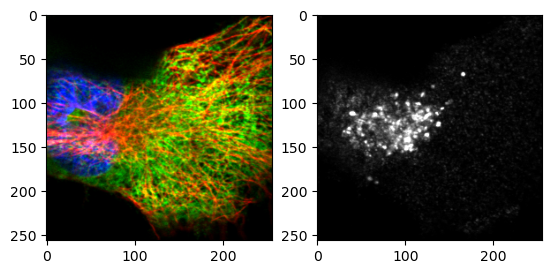

In [63]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow((sample["ref-image"] + 1) / 2)
axes[1].imshow((sample["image"] + 1) / 2)

In [43]:
info = info_list[sample["hpa_index"]]
plate_id = info["if_plate_id"]
position = info["position"]
image_id = str(plate_id) + "_" + str(position) + "_" + str(info["sample"])
im = Image.open(f'{smc_data_path}/hpa-webdataset-all-composite/images2/{image_id}.tif')
imarray = np.array(im)
imarray.shape

(1024, 1024, 4)

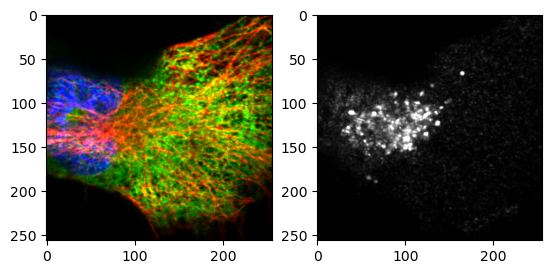

In [58]:
image = imarray[:, :, 1]
ref = imarray[:, :, [0, 3, 2]]
fig, axes = plt.subplots(1, 2)
cell_ref = ref[858-128:858+128, 584-128:584+128]
cell_prot = image[858-128:858+128, 584-128:584+128]
axes[0].imshow(cell_ref, vmin=0, vmax=255)
axes[1].imshow(cell_prot, cmap="gray", vmin=0, vmax=255)

In [55]:
sample["ref-image"]

array([[[-0.9607843 , -0.9137255 , -1.        ],
        [-0.9764706 , -0.9137255 , -1.        ],
        [-0.96862745, -0.8352941 , -1.        ],
        ...,
        [ 0.22352941, -0.8039216 , -1.        ],
        [ 0.11372549, -0.827451  , -1.        ],
        [-0.16078432, -0.8901961 , -1.        ]],

       [[-0.9843137 , -0.92156863, -1.        ],
        [-0.9529412 , -0.9137255 , -1.        ],
        [-0.8980392 , -0.9137255 , -1.        ],
        ...,
        [ 0.22352941, -0.8901961 , -1.        ],
        [-0.09803922, -0.8745098 , -1.        ],
        [-0.39607844, -0.9137255 , -1.        ]],

       [[-1.        , -0.92156863, -1.        ],
        [-0.96862745, -0.8666667 , -1.        ],
        [-0.92156863, -0.8980392 , -1.        ],
        ...,
        [ 0.09803922, -0.8352941 , -1.        ],
        [-0.27058825, -0.92941177, -1.        ],
        [-0.45882353, -0.9372549 , -1.        ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1